# Entorno

In [1]:
import torch
import torchaudio
import numpy as np
import torch.nn as nn
from random import randint
import pytorch_lightning as pl
from pydub import AudioSegment
from scripts.extract import load_heart_noised_paths
from pytorch_lightning.loggers import TensorBoardLogger
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import CyclicLR, ReduceLROnPlateau
from scripts.plot import plot_audio_sample, plot_prediction_from_dataset
from pytorch_lightning.callbacks import (
    ModelCheckpoint,
    EarlyStopping,
    LearningRateMonitor,
)

# Relación de datos

In [2]:
heart_noised = load_heart_noised_paths(
    # clean_dir="data/heart_sound_test_small",
    # noised_dir="data/heart_noised_test_small",
    clean_dir="data/heart_sound_healthy",
    noised_dir="data/heart_noised_healthy",
)

heart_noised[:3]

[('data/heart_sound_healthy/train/healthy/b0123.wav',
  'data/heart_noised_healthy/-train-healthy-b0123_seg_220noise_-19dB_louder.wav'),
 ('data/heart_sound_healthy/train/healthy/b0123.wav',
  'data/heart_noised_healthy/-train-healthy-b0123_seg_327noise_-22dB_louder.wav'),
 ('data/heart_sound_healthy/train/healthy/b0123.wav',
  'data/heart_noised_healthy/-train-healthy-b0123_seg_226noise_-18dB_louder.wav')]

# Cómo suena?

In [3]:
test = heart_noised[randint(0, len(heart_noised))]

audio_clean = AudioSegment.from_file(test[0])
audio_noisy = AudioSegment.from_file(test[1])

In [4]:
audio_clean

In [5]:
audio_noisy

# Cómo se ve?

In [6]:
clean_array = np.array(audio_clean.get_array_of_samples())
noisy_array = np.array(audio_noisy.get_array_of_samples())
clean_array.shape, noisy_array.shape

((34596,), (34596,))

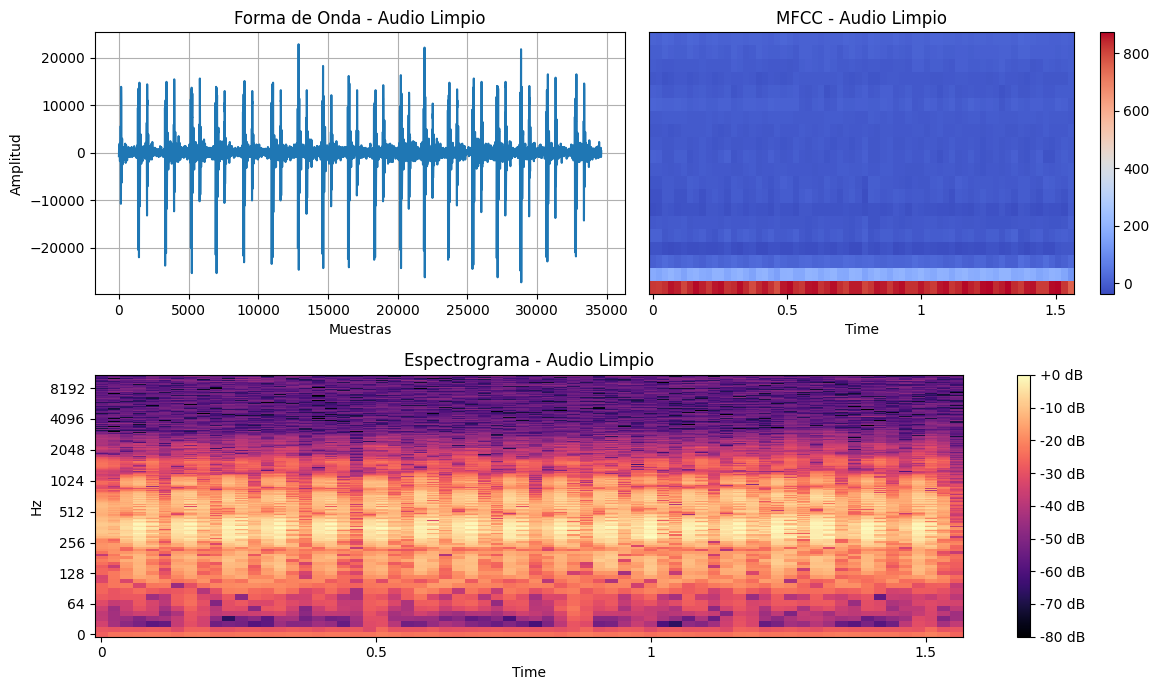

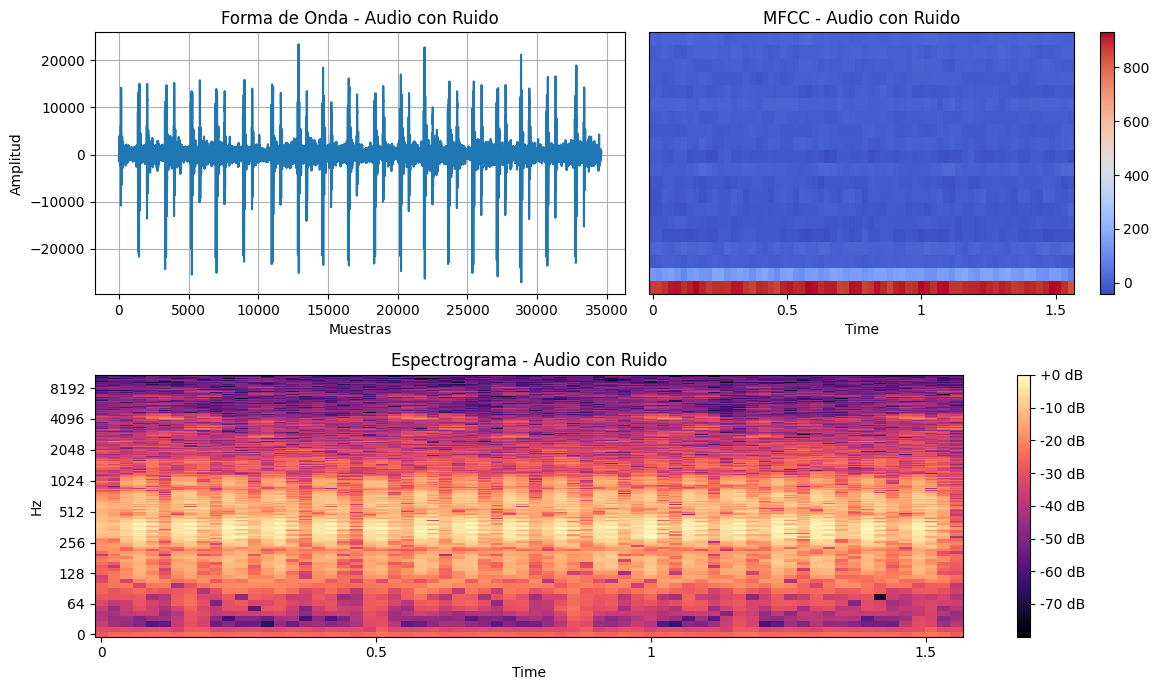

In [7]:
plot_audio_sample(clean_array, "Audio Limpio")
plot_audio_sample(noisy_array, "Audio con Ruido")

# CustomDataset class

In [8]:
class CoraDenoiserDataset(Dataset):
    def __init__(self, data_tuples, transform=None, duration=None):
        self.data_tuples = data_tuples
        self.transform = transform
        if duration is None:
            self.min_duration = self.calculate_min_duration(level=10)
        else:
            self.min_duration = duration

    def __len__(self):
        return len(self.data_tuples)

    def calculate_min_duration(self, level: int = 1):
        self.durations = []
        for _, audio_path in self.data_tuples:
            audio, _ = torchaudio.load(audio_path)
            self.durations.append(audio.shape[-1])

        min_dur = min(self.durations) // level
        return min_dur * level

    def adjust_audio_duration(self, audio, duration):
        if audio.shape[-1] > duration:
            audio = audio[..., :duration]
        return audio

    def normalize_audio(self, audio):
        normalized = (audio - audio.mean()) / audio.std()
        return normalized

    def preprocess_audio(self, idx, is_clean):
        subidx = 0 if is_clean else 1
        audio_path = self.data_tuples[idx][subidx]
        audio, sample_rate = torchaudio.load(audio_path)
        audio = self.adjust_audio_duration(audio, self.min_duration)
        audio = self.normalize_audio(audio)
        return audio, sample_rate

    def __getitem__(self, idx):
        clean_audio, sample_rate = self.preprocess_audio(idx, is_clean=True)
        noisy_audio, _ = self.preprocess_audio(idx, is_clean=False)

        if self.transform:
            clean_audio = self.transform(clean_audio, sample_rate)
            noisy_audio = self.transform(noisy_audio, sample_rate)

        return clean_audio, noisy_audio

In [9]:
from scripts.transform import spec_n_mfcc

denoiser_dataset = CoraDenoiserDataset(
    data_tuples=heart_noised,
    # transform=spec_n_mfcc,
    duration=None
)

print("Pairs of sounds: ", len(denoiser_dataset))
print("Min audio duration: ", denoiser_dataset.min_duration)
denoiser_dataset[5][0].shape, denoiser_dataset[5][1].shape

Pairs of sounds:  30227
Min audio duration:  13210


(torch.Size([1, 13210]), torch.Size([1, 13210]))

In [10]:
clean = denoiser_dataset[5][0][..., :denoiser_dataset.min_duration]
clean.shape, clean.mean(), clean.std()

(torch.Size([1, 13210]), tensor(3.1422e-08), tensor(1.0000))

In [11]:
noisy = denoiser_dataset[5][1][..., :denoiser_dataset.min_duration]
noisy.shape, noisy.mean(), noisy.std()

(torch.Size([1, 13210]), tensor(2.0503e-08), tensor(1.))

# Arquitectura

In [12]:
import torch
import torch.nn as nn
import pytorch_lightning as pl

class CoraDenoiser(pl.LightningModule):
    def __init__(self, input_size: int):
        super().__init__()
        
        self.lstm = nn.LSTM(input_size, hidden_size=2048, num_layers=1, batch_first=True, bidirectional=False)
        self.dense1 = nn.Linear(2048, 2048)
        self.dense2 = nn.Linear(2048, 1024)
        self.dense3 = nn.Linear(1024, 1024)
        self.output_layer = nn.Linear(1024, input_size)
        
    def forward(self, x):
        # print('x', x.shape)
        lstm_output, _ = self.lstm(x)
        # print('lstm_output', lstm_output.shape)
        lstm_output = lstm_output[:, -1, :].unsqueeze(dim=1)  # Get the output of the last time step
        # print('lstm_output', lstm_output.shape)
        dense1_output = self.dense1(lstm_output)
        # print('dense1_output', dense1_output.shape)
        dense2_output = self.dense2(dense1_output)
        # print('dense2_output', dense2_output.shape)
        dense3_output = self.dense3(dense2_output)
        # print('dense3_output', dense3_output.shape)
        output = self.output_layer(dense3_output)
        # print('output', output.shape)
        return output
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        predictions = self(x)
        loss = nn.MSELoss()(predictions, y)
        self.log("train_loss", loss, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        predictions = self(x)
        loss = nn.MSELoss()(predictions, y)
        self.log("val_loss", loss, on_epoch=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        scheduler = {
            "scheduler": ReduceLROnPlateau(optimizer, patience=3),
            "monitor": "val_loss",  # Métrica para monitorear
            "interval": "epoch",    # Frecuencia de ajuste del LR scheduler
            "frequency": 1          # Igual a interval, ya que estamos usando "epoch"
        }

        # scheduler = {
        #     "scheduler": CyclicLR(
        #         optimizer, base_lr=0.001, max_lr=0.01, cycle_momentum=False
        #     ),
        #     "interval": "step",  # Frecuencia de ajuste del LR scheduler (en cada paso)
        # }

        return [optimizer], [scheduler]


# Entrenamiento, validación y prueba

In [13]:
batch_size = 50
train_ratio = 0.7
val_ratio = 0.15

train_size = int(train_ratio * len(denoiser_dataset))
val_size = int(val_ratio * len(denoiser_dataset))
test_size = len(denoiser_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    denoiser_dataset, [train_size, val_size, test_size]
)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
)
val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    shuffle=False,
)
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=False)

# Callbacks

In [14]:
checkpoint = ModelCheckpoint(
    monitor="val_loss",
    dirpath="checkpoints/",
    filename="autoencoder-{epoch:02d}-{val_loss:.4f}",
    save_top_k=1,
    mode="min",
)

early_stopping = EarlyStopping(monitor="val_loss", patience=10, mode="min")

lr_monitor = LearningRateMonitor(logging_interval="epoch")

callbacks = [checkpoint, early_stopping, lr_monitor]

# Entrenamiento

In [15]:
model = CoraDenoiser(input_size=denoiser_dataset[0][0].shape[-1])

logger = TensorBoardLogger("logs/", name="cora_cleaner")

trainer = pl.Trainer(max_epochs=500, callbacks=callbacks, logger=logger)
trainer.fit(model, train_dataloader, val_dataloader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/efrainflores/.local/share/virtualenvs/cora_cleaner-eXlQ0b7N/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:615: UserWarning: Checkpoint directory /Users/efrainflores/Desktop/Nowports/repos/cora_cleaner/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name         | Type   | Params
----------------------------------------
0 | lstm         | LSTM   | 125 M 
1 | dense1       | Linear | 4.2 M 
2 | dense2       | Linear | 2.1 M 
3 | dense3       | Linear | 1.0 M 
4 | output_layer | Linear | 13.5 M
----------------------------------------
145 M     Trainable params
0         Non-trainable params
145 M     Total params
583.577   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/efrainflores/.local/share/virtualenvs/cora_cleaner-eXlQ0b7N/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/Users/efrainflores/.local/share/virtualenvs/cora_cleaner-eXlQ0b7N/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 499: 100%|██████████| 424/424 [00:46<00:00,  9.17it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 499: 100%|██████████| 424/424 [00:46<00:00,  9.17it/s, v_num=3]


# Predicción

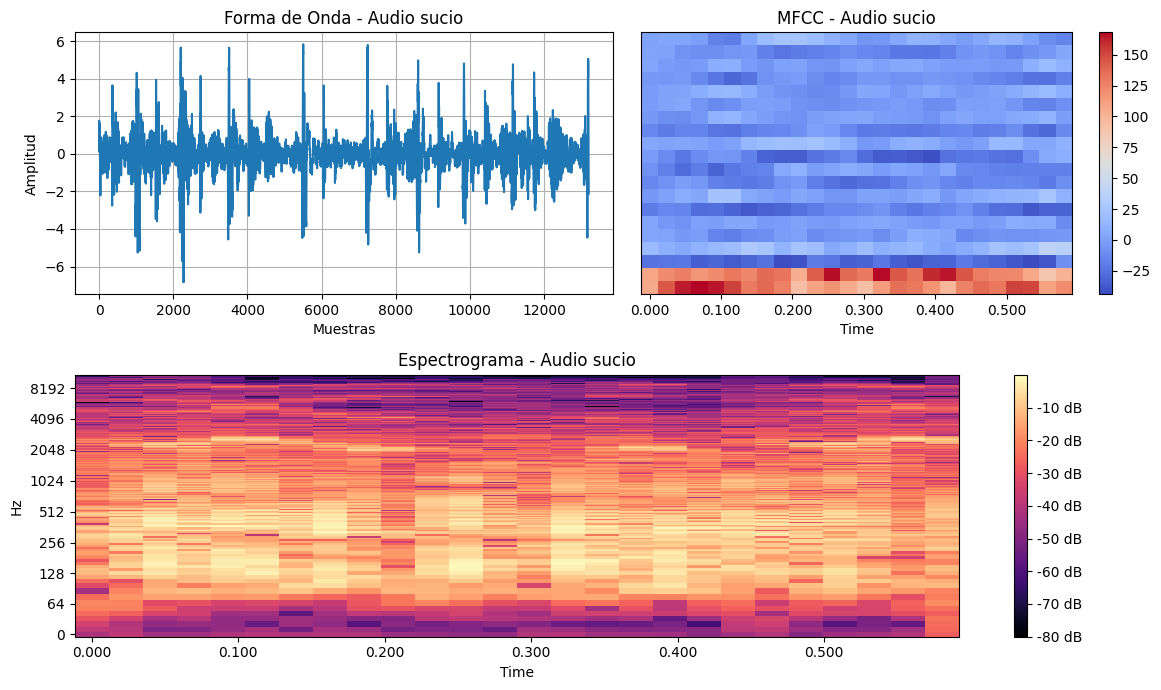

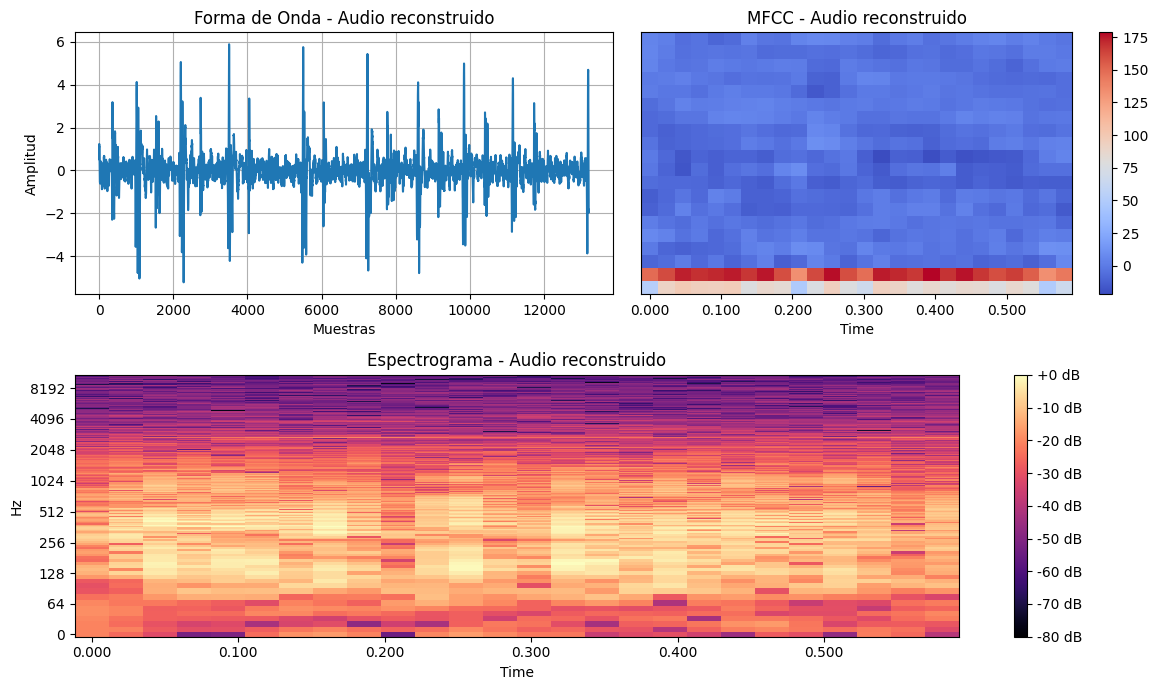

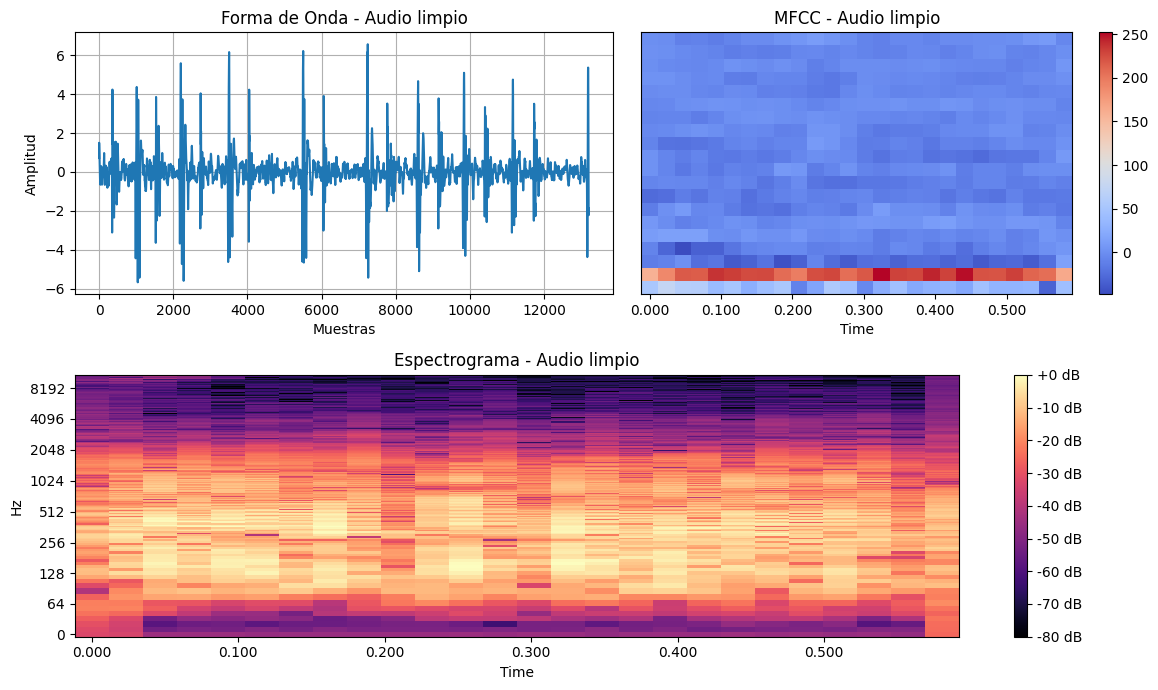

In [21]:
plot_prediction_from_dataset(
    model=model,
    dataset=denoiser_dataset,
    duration=denoiser_dataset.min_duration,
    idx=randint(0, len(denoiser_dataset))
)

In [17]:
# Descomentar para revisar el Tensorboard en web
# !tensorboard --logdir=path_to_logs_directory

# Otra opción es VisualStudioCode: Ctrl+Shift+P -> Launch Tensorboard